Dokumentation einfügen \\
Links für Quellcode einfügen

In [ ]:

!pip install --upgrade xlrd # important to upgrade to open xls file
!pip install git+https://github.com/shukon/HpBandSter.git # probably not necessary, additional to autoPyTorch
!pip install autoPyTorch 

  Cloning https://github.com/shukon/HpBandSter.git to /tmp/pip-req-build-mu4zsz40
  Running command git clone -q https://github.com/shukon/HpBandSter.git /tmp/pip-req-build-mu4zsz40


In [ ]:
# import needed packages
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
import numpy as np
import time
#read dataset
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/AutoML/Concrete_Data.xls', engine='xlrd')
data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [ ]:
# Generate Training, Test and Validation Dataset
X = data.iloc[:, 0:8].to_numpy()
y = data.iloc[:, 8].to_numpy()

print('Size of X: ', X.shape)

X_train, X_vt, y_train, y_vt = sklearn.model_selection.train_test_split(X, y, train_size=0.7,random_state=1)
X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X_vt, y_vt, train_size=0.5,random_state=1)

Size of X:  (1030, 8)


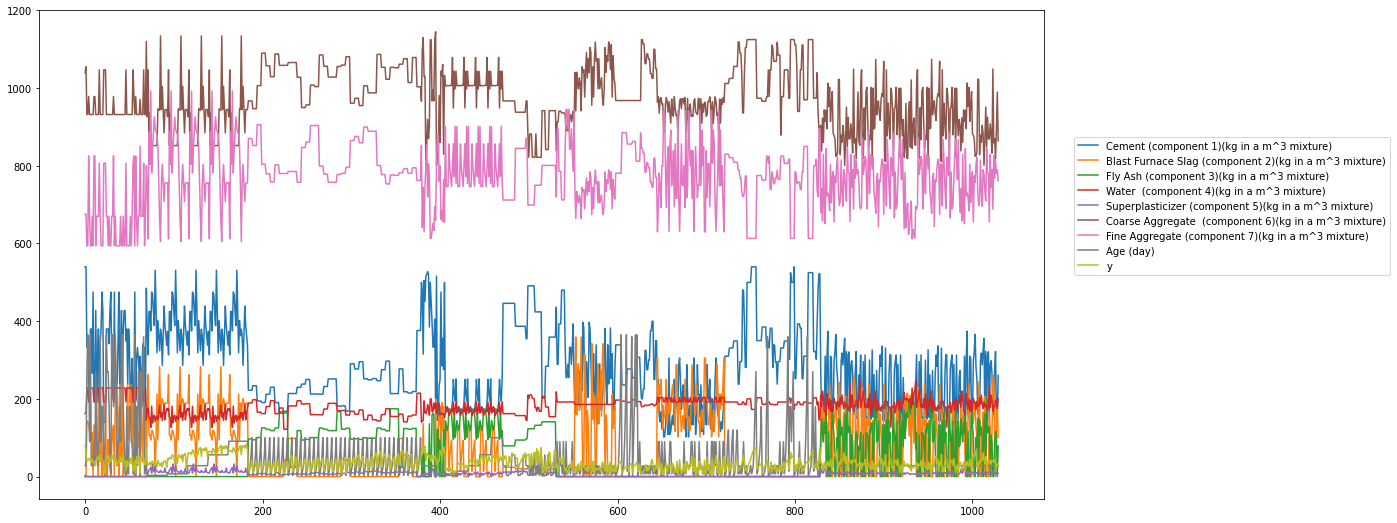

In [ ]:
# Plot data
plt.figure(figsize=(18,9))
for i, col in zip(range(8), data.columns):
  plt.plot(X[:, i], label=col)
plt.plot(y, label='y')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 0.75))

In [ ]:
#Korrelationskoeffizienten
for i in range(8):
  print(data.columns[i], ' Pearson-Korrelation: ', np.corrcoef(X_train[:, i], y_train)[0,1])

Cement (component 1)(kg in a m^3 mixture)  Pearson-Korrelation:  0.4995905451538622
Blast Furnace Slag (component 2)(kg in a m^3 mixture)  Pearson-Korrelation:  0.15837448245550131
Fly Ash (component 3)(kg in a m^3 mixture)  Pearson-Korrelation:  -0.0942189739290216
Water  (component 4)(kg in a m^3 mixture)  Pearson-Korrelation:  -0.3008787970699165
Superplasticizer (component 5)(kg in a m^3 mixture)  Pearson-Korrelation:  0.3876871087670462
Coarse Aggregate  (component 6)(kg in a m^3 mixture)  Pearson-Korrelation:  -0.21266256414202864
Fine Aggregate (component 7)(kg in a m^3 mixture)  Pearson-Korrelation:  -0.14997209237751324
Age (day)  Pearson-Korrelation:  0.3160405307364415


In [ ]:
# Generate Dataset Class for PyTorch, so we can easily use the dataset for batch learning
class ConcreteDataset(Dataset):
  def __init__(self, data, labels):
    # takes input data and target labels with dtype numpy array and converts it to a FloatTensor
    self.data = torch.from_numpy(data).float() # Input Data
    self.labels = torch.from_numpy(labels).float() # Target Labels
  def __len__(self):
    # returns size of dataset
    return len(self.labels)
  def __getitem__(self, idx):
    # returns a single data row with target label
    X = self.data[idx, :]
    y = self.labels[idx].view(-1)
    return X, y

In [ ]:
# Generate Dataloaders for Training and Validation Data and determine batch size
training_data = ConcreteDataset(X_train, y_train)
train_dataloader = DataLoader(training_data, batch_size = 10, shuffle=True)
# It's called test data but it's used for validation while training
test_data = ConcreteDataset(X_val, y_val)
test_dataloader = DataLoader(test_data, batch_size = 10)

In [ ]:
# check if dataloader works
data, labels = next(iter(train_dataloader))
labels

tensor([[23.6392],
        [38.7003],
        [32.9225],
        [46.2018],
        [46.8016],
        [17.5403],
        [13.7137],
        [45.3675],
        [50.7730],
        [58.7847]])

In [ ]:
# R2 Score for Validation Dataset 
def test_r2():
  model.eval()
  data, labels = next(iter(test_dataloader))
  data = data.to(device)
  labels = labels.to(device)
  outputs = model(data)

  return sklearn.metrics.r2_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())

In [ ]:
# tested this physical loss to get better results. didnt work.
# ReLU hits as long as output for cement from neural network and target label of cement isn't similiar + weight term
def phy_loss(output, target):
  mse = nn.MSELoss()
  phy1 = torch.abs(torch.sum(output[:, 0] - target[:, 0]))
  ReLU = nn.ReLU()
  loss = mse(output, target) + 0.01*ReLU(phy1)
  return loss

In [ ]:
# Generate Multilayer-Perceptron with ReLU Activation Function. Use of Adam Optimizer and MSELoss.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(8, 100)
        self.linear2 = nn.Linear(100, 50)
        self.linear3 = nn.Linear(50, 50)
        self.linear4 = nn.Linear(50, 10)
        self.linear5 = nn.Linear(10, 1)
        self.af = nn.ReLU()
    def forward(self, x):
        x = self.af(self.linear1(x))
        x = self.af(self.linear2(x))
        x = self.af(self.linear3(x))
        x = self.af(self.linear4(x))
        x= self.linear5(x)
        return x

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
print(model)

MLP(
  (linear1): Linear(in_features=8, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=50, bias=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=1, bias=True)
  (af): ReLU()
)


In [ ]:
# Training of MLP. Termination Criterions: max 6000 epochs. 1000 seconds.
start_time = time.time()
n_epochs = 6000
list_loss = []
test_list_loss = []
for epoch in range(n_epochs):
    model.train()
    # monitor training loss
    train_loss = 0.0
    for data, target in train_dataloader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_dataloader.dataset)
    list_loss.append(train_loss)
    r2_test = test_r2()
    test_list_loss.append(r2_test)
    print('Epoch: {} \tTraining Loss: {:.6f} \t R^2 Test: {}'.format(
        epoch+1, 
        train_loss,
        r2_test
        ))
    timer = time.time() - start_time
    if timer >= 1000:
      break
print("--- %s seconds ---" % (time.time() - start_time))

Epoch: 1 	Training Loss: 334.349467 	 R^2 Test: -0.06226538158171402
Epoch: 2 	Training Loss: 203.619576 	 R^2 Test: -0.1521822049931747
Epoch: 3 	Training Loss: 160.976384 	 R^2 Test: 0.4442655539604169
Epoch: 4 	Training Loss: 127.759364 	 R^2 Test: 0.4369212118942184
Epoch: 5 	Training Loss: 113.601576 	 R^2 Test: 0.5384606886868946
Epoch: 6 	Training Loss: 97.003622 	 R^2 Test: -0.36829682213391246
Epoch: 7 	Training Loss: 136.655358 	 R^2 Test: 0.6164911913719161
Epoch: 8 	Training Loss: 85.186664 	 R^2 Test: 0.5638375723208535
Epoch: 9 	Training Loss: 75.975097 	 R^2 Test: 0.21729184522205025
Epoch: 10 	Training Loss: 75.878043 	 R^2 Test: 0.765017640479477
Epoch: 11 	Training Loss: 63.915223 	 R^2 Test: 0.5754429023716436
Epoch: 12 	Training Loss: 63.510171 	 R^2 Test: 0.7691266821233048
Epoch: 13 	Training Loss: 61.207643 	 R^2 Test: 0.6441441718466643
Epoch: 14 	Training Loss: 60.377759 	 R^2 Test: 0.6443160782983312
Epoch: 15 	Training Loss: 53.696730 	 R^2 Test: 0.6597176518

In [ ]:
runs = [] # initialize list of all test data r2 scores


In [ ]:
# Get R2 Score of MLP for Test Data
model.eval()
X_test = X_test
y_test = y_test
outputs = model(X_test)

run = sklearn.metrics.r2_score(y_test.cpu().detach().numpy(), outputs.cpu().detach().numpy())
runs.append(run)

In [ ]:
# Print average R2 Score for MLP
print(sum(runs)/len(runs))


0.8786520235239297


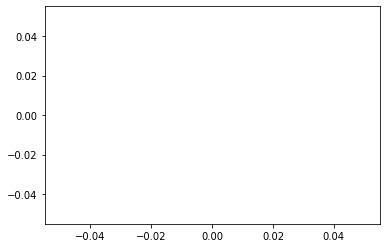

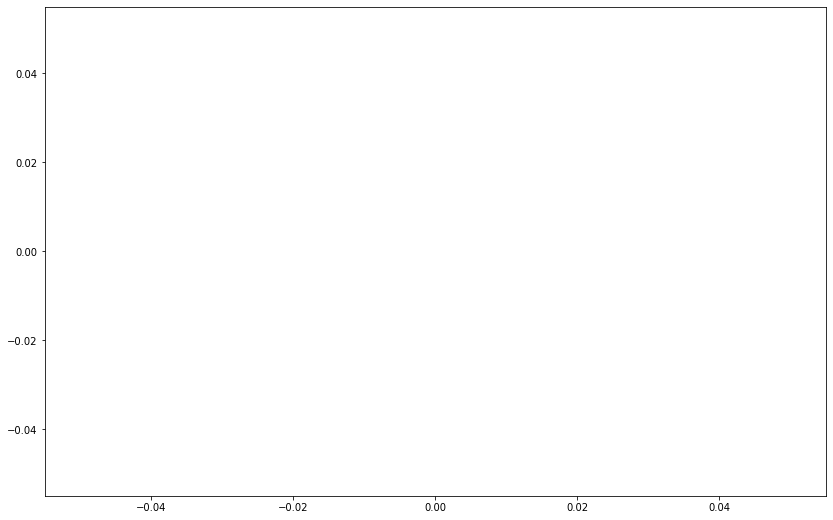

In [ ]:
# Plot Training Loss
plt.figure()
plt.plot(list_loss[500:])
# Plot R2 Score of Validation Data
plt.figure(figsize=(14, 9))
plt.plot(test_list_loss[500:])

# NAS


Used NAS based on following example: https://automl.github.io/Auto-PyTorch/master/examples/20_basics/example_tabular_regression.html#sphx-glr-examples-20-basics-example-tabular-regression-py

In [ ]:
# Generate Train and Test Data
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/AutoML/Concrete_Data.xls', engine='xlrd')
X = data.iloc[:, 0:8].to_numpy()
y = data.iloc[:, 8].to_numpy()

print('Size of X: ', X.shape)

X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y,random_state=1)

Size of X:  (1030, 8)


In [ ]:
# Import TabularRegressionTask from autoPyTorch
from autoPyTorch.api.tabular_regression import TabularRegressionTask

api = TabularRegressionTask()

# .search() takes train and test data, asks for optimization metric and how long the algorithm should run.
# set memory_limit=None to use complete memory instead of default 4096 MB, so that used algorithms dont crash.
api.search(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test.copy(),
    y_test=y_test.copy(),
    optimize_metric='r2',
    total_walltime_limit=1000,
    func_eval_time_limit_secs=50,
    memory_limit=None
)

[WARNING] [2022-04-28 09:48:57,323:Client-Validation] AutoPyTorch previously received features of type <class 'numpy.ndarray'> yet the current features have type <class 'pandas.core.frame.DataFrame'>. Changing the dtype of inputs to an estimator might cause problems
[WARNING] [2022-04-28 09:48:57,348:Client-Validation] AutoPyTorch previously received features of type <class 'numpy.ndarray'> yet the current features have type <class 'pandas.core.frame.DataFrame'>. Changing the dtype of inputs to an estimator might cause problems
[ERROR] [2022-04-28 09:49:00,772:Client-AutoPyTorch:6c232c1a-c6d8-11ec-8182-0242ac1c0002:1] Traditional prediction for lgb failed with run state StatusType.CRASHED.
Additional info:
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autoPyTorch/evaluation/tae.py", line 39, in fit_predict_try_except_decorator
    ta(queue=queue, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/autoPyTorch/evaluation/train_evaluato

/usr/local/lib/python3.7/dist-packages/smac/intensification/parallel_scheduling.py:152: UserWarning: Hyperband is intended to be used with more than 1 worker but num_workers=1
  num_workers
/usr/local/lib/python3.7/dist-packages/smac/intensification/parallel_scheduling.py:152: UserWarning: Hyperband is intended to be used with more than 1 worker but num_workers=1
  num_workers
/usr/local/lib/python3.7/dist-packages/smac/intensification/parallel_scheduling.py:152: UserWarning: Hyperband is intended to be used with more than 1 worker but num_workers=1
  num_workers
/usr/local/lib/python3.7/dist-packages/smac/intensification/parallel_scheduling.py:152: UserWarning: Hyperband is intended to be used with more than 1 worker but num_workers=1
  num_workers
/usr/local/lib/python3.7/dist-packages/smac/intensification/parallel_scheduling.py:152: UserWarning: Hyperband is intended to be used with more than 1 worker but num_workers=1
  num_workers
/usr/local/lib/python3.7/dist-packages/smac/intens

In [ ]:
y_pred = api.predict(X_test)

# Rescale the Neural Network predictions into the original target range
score = api.score(y_pred, y_test)

print(score)

# Print the final ensemble built by AutoPyTorch
print(api.show_models())

# Print statistics from search
print(api.sprint_statistics())

# wie wird der validation score gemessen?

{'r2': 0.9241080391101641}
|    | Preprocessing                                                 | Estimator                                                       |   Weight |
|---:|:--------------------------------------------------------------|:----------------------------------------------------------------|---------:|
|  0 | None                                                          | CBLearner                                                       |     0.72 |
|  1 | SimpleImputer,NoEncoder,StandardScaler,NoFeaturePreprocessing | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential |     0.12 |
|  2 | None                                                          | ETLearner                                                       |     0.08 |
|  3 | SimpleImputer,NoEncoder,StandardScaler,NoFeaturePreprocessing | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential |     0.06 |
|  4 | SimpleImputer,NoEncoder,StandardScaler,NoFeaturePreprocessing | no embedding,S

Wie sehen die Netzwerkarchitekturen der AutoML Lösung aus?
